In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import bison
import pyobs

# plt.rcParams.update({
#     "text.usetex"      : True,
#     "font.family"      : "Helvetica",
#     "mathtext.fontset" : "dejavuserif"
# })
plt.rcParams.update({
    "axes.axisbelow"   : True,
})

In [3]:
### data loading ###
data = bison.load("Cnfgs_measurement/WF-slices_beta617_lat32x64.dat")

L1, L2, L3, T = data['Lattice']
V         =  L1 * L2 * L3 * T
D         =  4
beta      =  data['beta coupling']
MC_step   =  data['MC measure step']
eps_WF    =  data['epsilon WF']
WF_evol   =  data['WF evolutions from t = 0']
WF_step   =  data['WF measure step']
Nwf       =  WF_evol // WF_step + 1
t_WF      = np.array([eps_WF * WF_step * i for i in range(Nwf)])

Ncnfg0 = 0
for key in data:
    if key.startswith('Configuration'):
        Ncnfg0 += 1

Ntherm0 = 200
skip = (5 * 20 * MC_step - Ntherm0) // MC_step
Ncnfg = Ncnfg0 - skip

print(f"\n Total configs. = {Ncnfg} (after removing initial due to therm.)")

[Bison] : Reading file Cnfgs_measurement/WF-slices_beta617_lat32x64.dat
[Bison] : File created by gmorandi at ampere on Tue Dec 19 00:02:04 2023
[Bison] : Read 283.844 MB at 110.825 MB/s

 Total configs. = 3080 (after removing initial due to therm.)


In [4]:
################################################
### Loading t0/a^2 values both Clov and Plaq ###
t0EClov = pyobs.load(f"PyObs/beta617_lat{L1}x{T}/t0EClov.pyobs")
t0EPlaq = pyobs.load(f"PyObs/beta617_lat{L1}x{T}/t0EPlaq.pyobs")
print(f"\n From interpolation  --->  Clov  :  t0/a^2 = {t0EClov}")
print(f" From interpolation  --->  Plaq  :  t0/a^2 = {t0EPlaq}")
################################################

[Bison] : Reading file PyObs/beta617_lat32x64/t0EClov.pyobs
[Bison] : File created by gmorandi at ampere on Sat Mar 23 11:03:15 2024
[Bison] : Read 0.0279646 MB at 4.56407 MB/s
[Bison] : Reading file PyObs/beta617_lat32x64/t0EPlaq.pyobs
[Bison] : File created by gmorandi at ampere on Sat Mar 23 11:03:15 2024
[Bison] : Read 0.0279064 MB at 5.10547 MB/s

 From interpolation  --->  Clov  :  t0/a^2 = 5.4999(70)

 From interpolation  --->  Plaq  :  t0/a^2 = 5.1271(66)



In [5]:
Corr_EEClov_tWF = pyobs.load(f"PyObs/beta617_lat{L1}x{T}/Corr_EEClov_tWF.pyobs")
Corr_EEPlaq_tWF = pyobs.load(f"PyObs/beta617_lat{L1}x{T}/Corr_EEPlaq_tWF.pyobs")

[Bison] : Reading file PyObs/beta617_lat32x64/Corr_EEClov_tWF.pyobs
[Bison] : File created by gmorandi at ampere on Sat Mar 23 11:06:35 2024
[Bison] : Read 91.8678 MB at 94.3722 MB/s
[Bison] : Reading file PyObs/beta617_lat32x64/Corr_EEPlaq_tWF.pyobs
[Bison] : File created by gmorandi at ampere on Sat Mar 23 11:06:46 2024
[Bison] : Read 91.8678 MB at 90.6237 MB/s


In [6]:
######################################################
### Choose a specific Wilson flow time to focus on ###
t0 = 5.50
i0 = int(np.around(t0 / (eps_WF * WF_step)))
######################################################

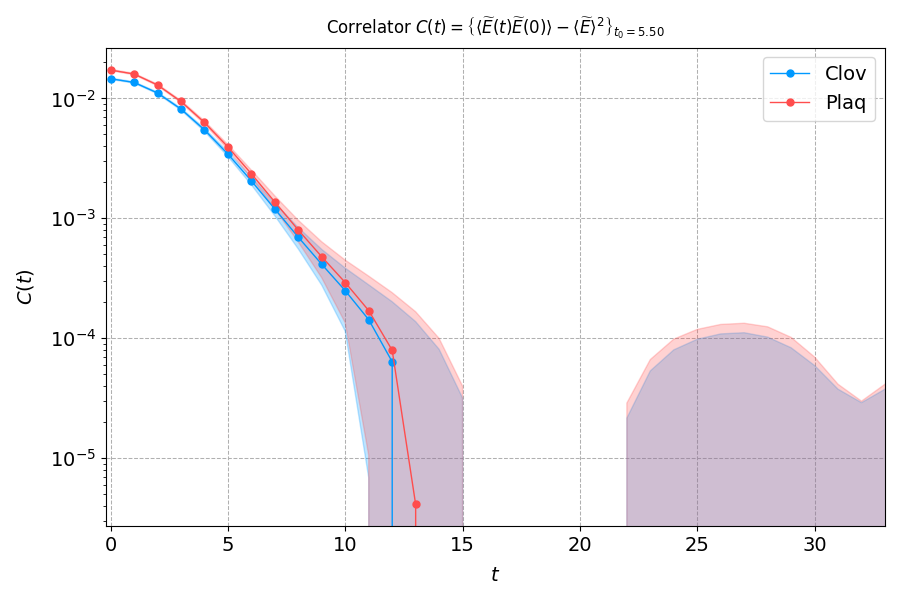

In [7]:
Ct_Clov, dCt_Clov = pyobs.remove_tensor(Corr_EEClov_tWF[i0,:]).error()
Ct_Plaq, dCt_Plaq = pyobs.remove_tensor(Corr_EEPlaq_tWF[i0,:]).error()

fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t) = \left \{{ \langle \widetilde{{E}}(t) \widetilde{{E}}(0) \rangle - \langle \widetilde{{E}} \rangle^2 \right \}}_{{t_0 = {t0:.2f}}}$", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.2, T/2+1])
# plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)
ax.set_yscale('log')

std = 1.0
ax.plot(np.arange(T), Ct_Clov, label=r'Clov', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(T), Ct_Clov + std * dCt_Clov, Ct_Clov - std * dCt_Clov, alpha=.25, color='#0099ff')
ax.plot(np.arange(T), Ct_Plaq, label=r'Plaq', linestyle='-', marker='o' , markersize=5.0, color='#ff4d4d', linewidth=1.0)
ax.fill_between(np.arange(T), Ct_Plaq + std * dCt_Plaq, Ct_Plaq - std * dCt_Plaq, alpha=.25, color='#ff4d4d')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [8]:
##################################
### Effective Mass computation ###
Tmin = 0
Tmax = T // 2

mass_Clov, dmass_Clov = pyobs.remove_tensor(pyobs.log(Corr_EEClov_tWF[i0,:Tmax-Tmin] / Corr_EEClov_tWF[i0,1:Tmax-Tmin+1])).error()
mass_Plaq, dmass_Plaq = pyobs.remove_tensor(pyobs.log(Corr_EEPlaq_tWF[i0,:Tmax-Tmin] / Corr_EEPlaq_tWF[i0,1:Tmax-Tmin+1])).error()
##################################

/knuthome/gmorandi/gabriele_py/lib64/python3.6/site-packages/pyobs/tensor/unary.py:26: RuntimeWarning: invalid value encountered in log
  new_mean = f(x.mean)


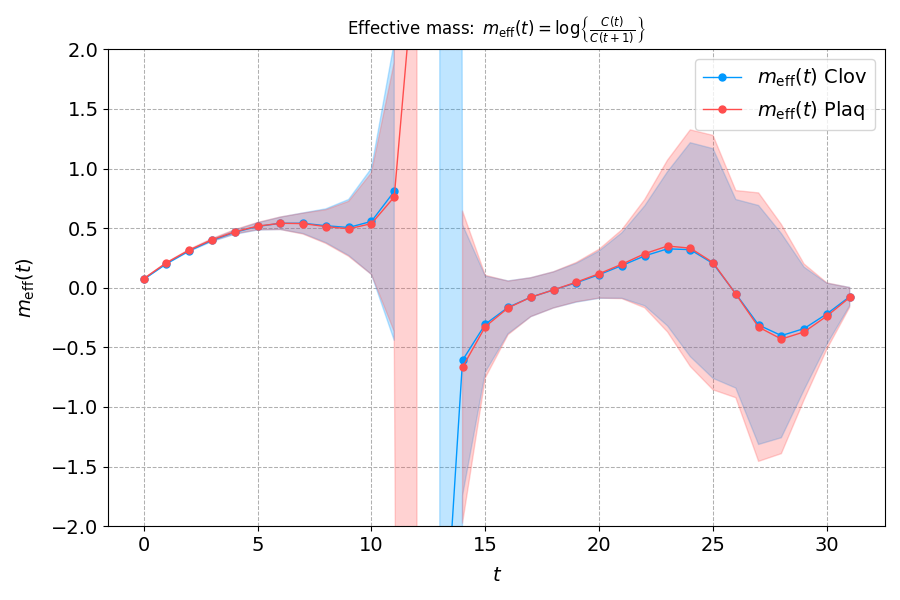

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Effective mass: $\,m_\mathrm{{eff}}(t) = \log \left \{{ \frac{{C(t)}}{{C(t+1)}} \right \}}$", pad=10)
ax.set_ylabel(r"$m_{\mathrm{eff}}(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
#plt.xlim([-0.2, 12])
plt.ylim([-2, 2])
ax.grid(linestyle = '--', linewidth = 0.75)

std = 1.0
ax.plot(np.arange(Tmin, Tmax), mass_Clov, label=r'$m_{\mathrm{eff}}(t)$ Clov', linestyle='-', marker='o' , markersize=5.0, color='#0099ff', linewidth=1.0)
ax.fill_between(np.arange(Tmin, Tmax), mass_Clov + std * dmass_Clov, mass_Clov - std * dmass_Clov, alpha=.25, color='#0099ff')
ax.plot(np.arange(Tmin, Tmax), mass_Plaq, label=r'$m_{\mathrm{eff}}(t)$ Plaq', linestyle='-', marker='o' , markersize=5.0, color='#ff4d4d', linewidth=1.0)
ax.fill_between(np.arange(Tmin, Tmax), mass_Plaq + std * dmass_Plaq, mass_Plaq - std * dmass_Plaq, alpha=.25, color='#ff4d4d')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

## Fits on $\langle \widetilde{E}(t) \widetilde{E}(0)  \rangle_\mathrm{Clov}$ and $\langle \widetilde{E}(t) \widetilde{E}(0)  \rangle_\mathrm{Plaq}$ 

In [10]:
##########################
### 2 independent fits ###
##########################
tmin = 6
tmax = 11
t = np.arange(tmin, tmax + 1)

W_Clov = 1. / dCt_Clov[tmin:tmax+1]**2
W_Plaq = 1. / dCt_Plaq[tmin:tmax+1]**2

t012_phys = pyobs.observable(description='(t_0,phys)^(1/2) fm')
t012_phys.create_from_cov('(t_0,phys)^(1/2)-Luscher', [0.176], [0.004**2])
const = 197.3 # MeV x fm ---> 1 = 197.3 MeV x fm 

# ######################
# ### double exp fit ###
# f  = lambda t, A0, A1, E0, E1: A0*np.exp(-t*E0) + A1*np.exp(-t*E1) 
# df = lambda t, A0, A1, E0, E1: [np.exp(-t*E0), np.exp(-t*E1), -t*A0*np.exp(-t*E0), -t*A1*np.exp(-t*E1)]
# fit_Clov = pyobs.mfit(t, W_Clov, f, df, v='t')
# f  = lambda t, B0, B1, E0, E1: B0*np.exp(-t*E0) + B1*np.exp(-t*E1) 
# df = lambda t, B0, B1, E0, E1: [np.exp(-t*E0), np.exp(-t*E1), -t*B0*np.exp(-t*E0), -t*B1*np.exp(-t*E1)]
# fit_Plaq = pyobs.mfit(t, W_Plaq, f, df, v='t')
# ######################

######################
### single exp fit ###
f  = lambda t, A0, E0: A0*np.exp(-t*E0) 
df = lambda t, A0, E0: [np.exp(-t*E0), -t*A0*np.exp(-t*E0)]
fit_Clov = pyobs.mfit(t, W_Clov, f, df, v='t')
f  = lambda t, B0, E0: B0*np.exp(-t*E0) 
df = lambda t, B0, E0: [np.exp(-t*E0), -t*B0*np.exp(-t*E0)]
fit_Plaq = pyobs.mfit(t, W_Plaq, f, df, v='t')
######################

In [11]:
# params_Clov = fit_Clov(pyobs.remove_tensor(Corr_EEClov_tWF[i0, tmin:tmax+1]), p0=[0.05, -0.05, 0.5, 0.8])
# m_glue_Clov = params_Clov[2]
params_Clov = fit_Clov(pyobs.remove_tensor(Corr_EEClov_tWF[i0, tmin:tmax+1]), p0=[0.04, 0.5])  
m_glue_Clov = params_Clov[1]

y_Clov = fit_Clov.eval(t, params_Clov)
print(f"\n Params  =   {params_Clov}")
print(f" sqrt(t0/a^2) x a m_glue = sqrt(t0) m_glue = {(t0EClov ** 0.5) * m_glue_Clov}")
print(f" m_glue[fm^-1] = {(t0EClov ** 0.5) * m_glue_Clov / t012_phys}")
print(f" m_glue[MeV]   = {(t0EClov ** 0.5) * m_glue_Clov / t012_phys * const}")

chisquare = 0.008186668935292383
chiexp    = 0.5791658261578783 +- 0.0691907855739553
minimizer iterations = 4
minimizer status: Levenberg-Marquardt: converged 1.0e-06 per-cent tolerance on fun
mfit executed in 0.0450022 secs

 Params  =   0.051(27)	0.536(93)

 sqrt(t0/a^2) x a m_glue = sqrt(t0) m_glue = 1.26(22)

 m_glue[fm^-1] = 7.1(1.3)

 m_glue[MeV]   = 1408(247)



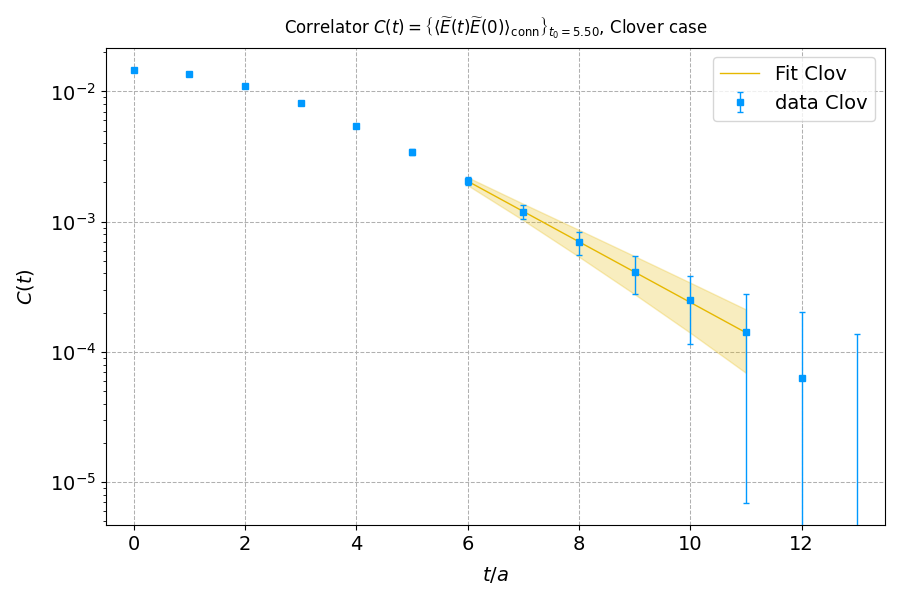

In [12]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t) = \left \{{ \langle \widetilde{{E}}(t) \widetilde{{E}}(0) \rangle_\mathrm{{conn}} \right \}}_{{t_0 = {t0:.2f}}}$, Clover case", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t/a$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.5, tmax+2.5])
# plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)
ax.set_yscale('log')

std = 1.0
ax.errorbar(np.arange(T), Ct_Clov, yerr=dCt_Clov, marker='s', markersize=4, linestyle='', capsize=2.5, label=f'data Clov', color='#0099ff', linewidth=1.0)
y, dy = y_Clov.error()
ax.plot(t, y, label=r'Fit Clov', linestyle='-', marker='' , markersize=5.0, color='#e6b800', linewidth=1.0)
ax.fill_between(t, y + std * dy, y - std * dy, alpha=.25, color='#e6b800')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [13]:
# params_Plaq = fit_Plaq(pyobs.remove_tensor(Corr_EEPlaq_tWF[i0, tmin:tmax+1]), p0=[0.05, 0.05, 0.5, 0.8])
# m_glue_Plaq = params_Plaq[2]
params_Plaq = fit_Plaq(pyobs.remove_tensor(Corr_EEPlaq_tWF[i0, tmin:tmax+1]), p0=[0.05, 0.5])
m_glue_Plaq = params_Plaq[1]

y_Plaq = fit_Plaq.eval(t, params_Plaq)
print(f"\n Params  =   {params_Plaq}")
print(f" sqrt(t0/a^2) x a m_glue = sqrt(t0) m_glue = {(t0EPlaq ** 0.5) * m_glue_Plaq}")
print(f" m_glue[fm^-1] = {(t0EPlaq ** 0.5) * m_glue_Plaq / t012_phys}")
print(f" m_glue[MeV]   = {(t0EPlaq ** 0.5) * m_glue_Plaq / t012_phys * const}")

chisquare = 0.015704931098168007
chiexp    = 0.5686281354971684 +- 0.06776171861297521
minimizer iterations = 4
minimizer status: Levenberg-Marquardt: converged 1.0e-06 per-cent tolerance on fun
mfit executed in 0.040781 secs

 Params  =   0.057(30)	0.532(95)

 sqrt(t0/a^2) x a m_glue = sqrt(t0) m_glue = 1.21(21)

 m_glue[fm^-1] = 6.9(1.2)

 m_glue[MeV]   = 1352(242)



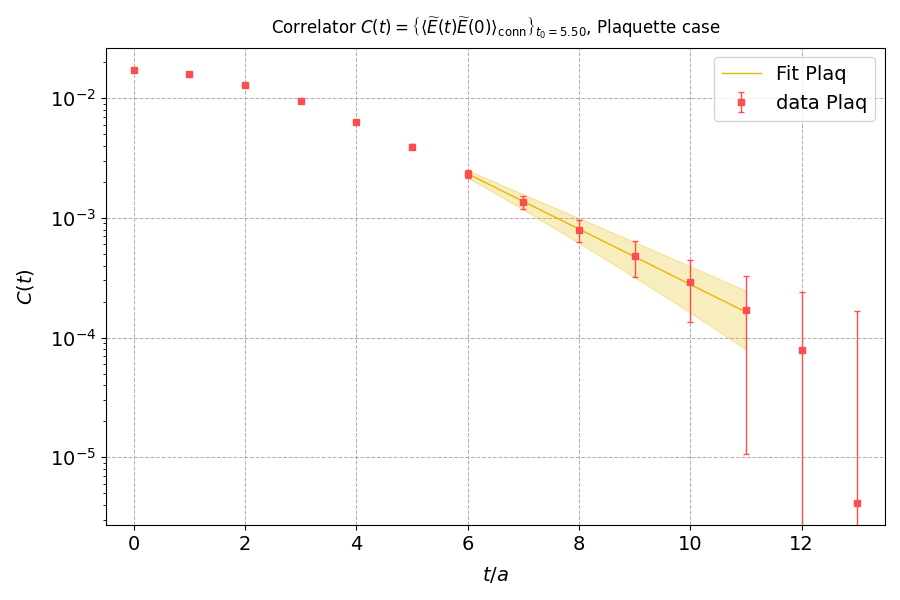

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
plt.subplots_adjust(top    = 0.92)
plt.subplots_adjust(bottom = 0.12)
plt.subplots_adjust(left   = 0.15)
plt.subplots_adjust(right  = 0.95)

fsize = 14

ax.set_title(rf"Correlator $C(t) = \left \{{ \langle \widetilde{{E}}(t) \widetilde{{E}}(0) \rangle_\mathrm{{conn}} \right \}}_{{t_0 = {t0:.2f}}}$, Plaquette case", pad=10)
ax.set_ylabel(r"$C(t)$", labelpad=10, rotation=90, fontsize=fsize)
ax.set_xlabel(r'$t/a$', labelpad=8, fontsize=fsize)

plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlim([-0.5, tmax+2.5])
# plt.ylim([1e-2, 1e1])
ax.grid(linestyle = '--', linewidth = 0.75)
ax.set_yscale('log')

std = 1.0
ax.errorbar(np.arange(T), Ct_Plaq, yerr=dCt_Plaq, marker='s', markersize=4, linestyle='', capsize=2.5, label=f'data Plaq', color='#ff4d4d', linewidth=1.0)
y, dy = y_Plaq.error()
ax.plot(t, y, label=r'Fit Plaq', linestyle='-', marker='' , markersize=5.0, color='#e6b800', linewidth=1.0)
ax.fill_between(t, y + std * dy, y - std * dy, alpha=.25, color='#e6b800')

ax.legend(loc='best', fontsize=fsize)

fig.tight_layout()

#plt.savefig("tau_int.pdf")

In [15]:
####################
### Combined fit ###
####################
fit_2 = fit_Clov + fit_Plaq
params_2 = fit_2([pyobs.remove_tensor(Corr_EEClov_tWF[i0, tmin:tmax+1]), pyobs.remove_tensor(Corr_EEPlaq_tWF[i0, tmin:tmax+1])], p0=[0.04, 0.5, 0.05])
m_Glue_comb = params_2[1]
# params_2 = fit_2([pyobs.remove_tensor(Corr_EEClov_tWF[i0, tmin:tmax+1]), pyobs.remove_tensor(Corr_EEPlaq_tWF[i0, tmin:tmax+1])], p0=[0.05, -0.05, 0.5, 0.8, 0.05, -0.05])
# m_Glue_comb = params_2[2]

y_comb = fit_2.eval([t, t], params_2)
print(f"\n Combined Fit : Params = {params_2}")
t0E = (t0EClov+t0EPlaq)*0.5
print(f" sqrt(t0/a^2) x a m_glue = sqrt(t0) m_glue = {(t0E ** 0.5) * m_Glue_comb}")
print(f" m_glue[fm^-1] = {(t0E ** 0.5) * m_Glue_comb / t012_phys}")
print(f" m_glue[MeV]   = {(t0E ** 0.5) * m_Glue_comb / t012_phys * const}")

chisquare = 0.025028679716557867
chiexp    = 1.1478764947722953 +- 0.09684589760460524
minimizer iterations = 4
minimizer status: Levenberg-Marquardt: converged 1.0e-06 per-cent tolerance on fun
mfit executed in 0.0395219 secs

 Combined Fit : Params = 0.050(27)	0.534(94)	0.058(31)

 sqrt(t0/a^2) x a m_glue = sqrt(t0) m_glue = 1.23(22)

 m_glue[fm^-1] = 7.0(1.2)

 m_glue[MeV]   = 1380(244)



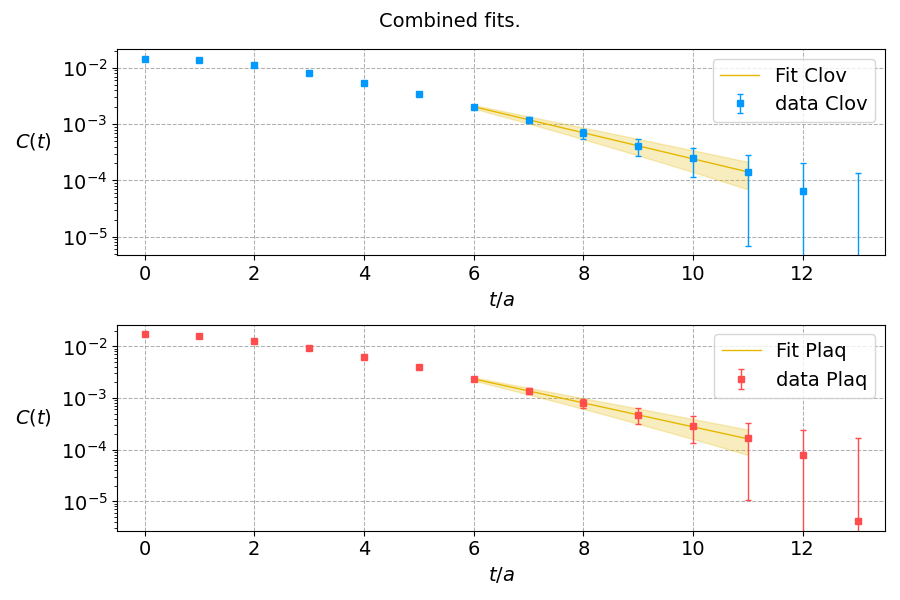

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(9, 6))

plt.subplots_adjust(top    = 0.95)
plt.subplots_adjust(bottom = 0.05)
plt.subplots_adjust(left   = 0.05)
plt.subplots_adjust(right  = 0.95)
fsize = 14
 
fig.suptitle(rf'Combined fits.', fontsize=fsize)

std = 1

y1, dy1 = y_comb[0].error()
y2, dy2 = y_comb[1].error()

ax[0].errorbar(np.arange(T), Ct_Clov, yerr=dCt_Clov, marker='s', markersize=4, linestyle='', capsize=2.5, label=f'data Clov', color='#0099ff', linewidth=1.0)
ax[0].plot(t, y1, label=rf'Fit Clov', linestyle='-', marker='' , markersize=5.0, color='#e6b800', linewidth=1.0)
ax[0].fill_between(t, y1 + std*dy1, y1 - std*dy1, alpha=.25, color='#e6b800')
ax[0].set_xlabel(rf'$t/a$', fontsize=fsize)
ax[0].set_ylabel(rf'$C(t)$', rotation=0, labelpad=20, fontsize=fsize)
ax[0].tick_params(axis='x', labelsize=fsize)
ax[0].tick_params(axis='y', labelsize=fsize)
ax[0].legend(loc='best', fontsize=fsize)
ax[0].grid(linestyle = '--', linewidth = 0.75)
ax[0].set_yscale('log')
ax[0].set_xlim([-0.5, tmax+2.5])

ax[1].errorbar(np.arange(T), Ct_Plaq, yerr=dCt_Plaq, marker='s', markersize=4, linestyle='', capsize=2.5, label=f'data Plaq', color='#ff4d4d', linewidth=1.0)
ax[1].plot(t, y2, label=rf'Fit Plaq', linestyle='-', marker='' , markersize=5.0, color='#e6b800', linewidth=1.0)
ax[1].fill_between(t, y2 + std*dy2, y2 - std*dy2, alpha=.25, color='#e6b800')
ax[1].set_xlabel(rf'$t/a$', fontsize=fsize)
ax[1].set_ylabel(rf'$C(t)$', rotation=0, labelpad=20, fontsize=fsize)
ax[1].tick_params(axis='x', labelsize=fsize)
ax[1].tick_params(axis='y', labelsize=fsize)
ax[1].legend(loc='best', fontsize=fsize)
ax[1].grid(linestyle = '--', linewidth = 0.75)
ax[1].set_yscale('log')
ax[1].set_xlim([-0.5, tmax+2.5])


# plt.yticks(fontsize=fsize)
# plt.xticks(fontsize=fsize)
#plt.xlim([-0.1, T // 2 + 0.5])
#plt.ylim([1e-2, 1e1])

fig.tight_layout()